# Are house prices contagious?
---
&nbsp;




The value of a house in the Netherlands is determined by various factors. One of these factors is looking at comparable houses in the neighborhood.
With this factor in mind, the following question can be asked:

Can an expensive house sale cause a ripple effect of an increasing house pricing and can this ripple effect be followed and predicted?


In order to be able to compare the house prices with each other, it has been decided within this project to calculate the price per square meter. However, this also has disadvantages since houses with certain elements (such as a new kitchen, a garden or near a highway) can influence the price.

Therefore it has been decided not to include these influences yet. This allows the whole project to be generalized. From there, it is always possible to include more variables.

&nbsp;

So lets get started...




In [1]:
#Imports
import json
from json import load
from datetime import datetime
from dateutil.relativedelta import relativedelta 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters

import gmaps
import gmaps.datasets
import time
from IPython.display import display

from bokeh.io import output_notebook, show, reset_output
from bokeh.models import (
    GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, Range1d, FixedTicker, FuncTickFormatter, LinearAxis
    )
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import RdYlGn8
from bokeh.io import export_png

from bokeh.plotting import figure, save
from bokeh.io.export import get_screenshot_as_png




## Loading some files.....

Within this project we load 3 files. 
- Amsterdam_sold2.json lists all the house details such as sale price, square meter and addresses.
    - I obtained this file from https://github.com/khpeek/funda-scraper. My thanks to <b>khpeek</b> for releasing the amsterdam2.json
- Geopost.csv. contains geolocations by address 
    - A bit below I will explain how an address is converted to a geolocation
- Keys.json contains all API keys

In [12]:
data = pd.read_json('amsterdam_sold2.json', orient='records')
pp = pd.read_csv('geopost.csv')
#temp fill
gmaps_key_lat_lon = 'gmaps_keys[0]'
gmaps_key_bokeh = 'gmaps_keys[1]'
gmaps_key_heat = 'gmaps_keys[2]'

#keys = pd.read_json('Keys.json', orient='records')

#gmaps_keys = keys
#gmaps_keys = gmaps_keys['key']

#gmaps_key_lat_lon = gmaps_keys[0]
#gmaps_key_bokeh = gmaps_keys[1]
#gmaps_key_heat = gmaps_keys[2]

#gmaps_keys

## Creating the geopost.csv

Below is the code that is responsible for converting address data to a longitude and latitude.
&nbsp;

<b> In summary:</b>
&nbsp;

We combine the postcode, street name and house number into 1 column.
We send this to google and google sends back a longitude and a latitude.
Then we save this in a CSV file.

In [13]:
#Google Geolocation address [adres] to longitude [lon] and latitude [lat]

#geopost = pd.DataFrame()
#geoposttop = pd.DataFrame()
#geocode_result = pd.DataFrame()
#geo = pd.DataFrame()

#geo = data
#geocode_result = pd.DataFrame()


#geopost["address"] = geo["address"] + " " + geo["postal_code"]
# geopost = geopost.head() testing purpose
#geopost

In [14]:
#import googlemaps

#gmaps_key = googlemaps.Client(key = gmaps_key_lat_lon)

#geopost["LAT"] = None
#geopost["LON"] = None

#for i in range(0, len(geopost), 1):
#    geocode_result = gmaps_key.geocode(geopost.iat[i,0])
#    try:
#        lat = geocode_result[0]["geometry"]['location']["lat"]
#        lon = geocode_result[0]["geometry"]['location']["lng"]
#        geopost.iat[i, geopost.columns.get_loc("LAT")] = lat
#        geopost.iat[i, geopost.columns.get_loc("LON")] = lon 
#    except:
#        lat = None
#        lon = None

#geopost
#geopost.to_csv('geopost.csv')

## Data cleaning

If we look at the data from amsterdam_sold2.json, you can see that there are a few houses that have been sold for an unrealistic amount.

<img src="vb1.PNG">

We filter this from the dataset by:

In [15]:
datacorrect = data
datacorrect = datacorrect.sort_values(by=['price'])
datacorrect = datacorrect[datacorrect.price > 5000]


## Only the necessary

Now we put together a dataframe which only contains the columns that apply within this project.

The first dataframe (<b>processed_data</b>) contains the columns: (<font color='blue'>gem2, postcode, adres, plaats_dt, oppervlakte</font>)
- Price and area can be converted into a price per square meter (<font color='blue'>gem2</font>).
- Address and zip code can be used for the geographical location.
- plaats_dt is needed to do time related calculations.

We fill <b> processed_pp </b> with the columns as:
- <font color='blue'>address</font> (contains the street name with house number and zip code)
- <font color='blue'>latitude</font>
- <font color='blue'>longitude</font>


In [16]:
#Filling DF with the values needed
processed_data = pd.DataFrame()
processed_data['gem2'] = datacorrect['price'] / datacorrect['area']
processed_data['postcode'] = datacorrect['postal_code']
processed_data['adres'] = datacorrect['address']
processed_data['plaats_dt'] = datacorrect['posting_date']
processed_data['oppervlakte'] = datacorrect['area']

processed_pp = pd.DataFrame()
processed_pp['adres'] = pp['address']
processed_pp['latitude'] = pp['LAT']
processed_pp['longitude'] = pp['LON']

### Sort, Merge and Combine 

To be precise, this piece of code is responsible for linking the 2 dataframes together. So that we have a latitude and longitude with the gem2 and plaats_dt.


In [17]:
processed_data["adres"] = processed_data["adres"] + " " + processed_data["postcode"]
processed_data_pp = pd.merge(processed_data, processed_pp, on='adres', how='inner')
processed_data_pp
processed_data_pp['plaats_dt'] =  pd.to_datetime(processed_data_pp['plaats_dt'], format='%d-%m-%Y')
processed_data_pp = processed_data_pp.sort_values(by=['plaats_dt'])

## Let's see what we got

Now that we have the data ready, we want to see whether there is actually an increase in the housing market for the entire data set.

If this leads to a negative result, it may be interesting to look more for a value decrease trend and not for a value increase trend.

To do this, we can use a chart like a scatterplot with a Linear regression.

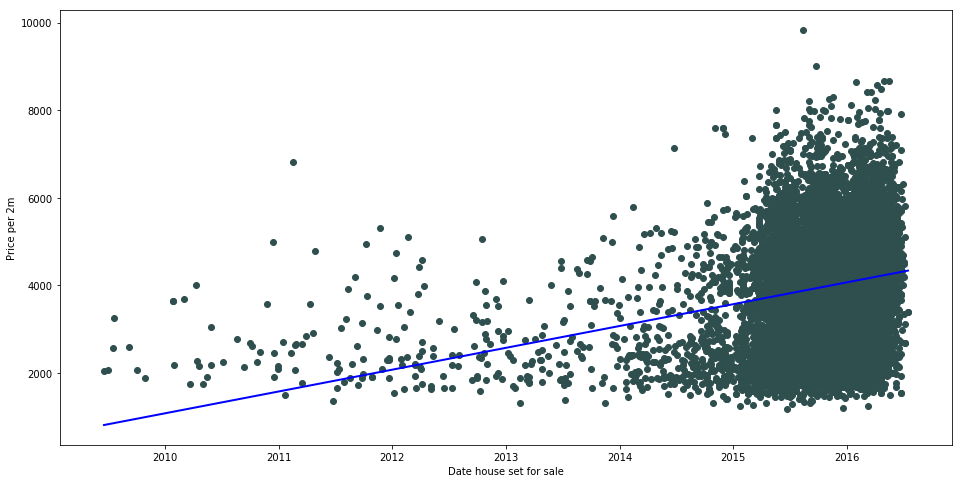

In [18]:
Linear_insight = pd.DataFrame()
Linear_insight['plaats_dt'] = processed_data_pp['plaats_dt']
Linear_insight['plaats_dt_read'] = processed_data_pp['plaats_dt']
Linear_insight['gem2'] = processed_data_pp['gem2']
Linear_insight['plaats_dt'] = pd.to_datetime(Linear_insight['plaats_dt']).apply(lambda date: date.toordinal())

X = Linear_insight['plaats_dt'].values.reshape(-1,1)
y = Linear_insight['gem2'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)

predictions = reg.predict(X)
plt.figure(figsize=(16, 8))
plt.scatter(
    Linear_insight['plaats_dt_read'],
    Linear_insight['gem2'],
    c='DarkSlateGray'
)
plt.plot(
    Linear_insight['plaats_dt'],
    predictions,
    c='blue',
    linewidth=2
)
plt.xlabel("Date house set for sale")
plt.ylabel("Price per 2m")
plt.show()

As can be seen in the scatter plot, it is unclear and skewed. We see that most data points are after somewhere 2014.

It is a logical choice to clean up the data for everything that falls below 2014.

Before we do that, maybe it is interesting to make a visualization of what this data looks like on a map. This could allow us to see if a cleanup for more points in the data is required.

## Just in case,  let's see that on a map 

The code below is responsible for plotting a map with the house prices per m2 on it.

This plotting was done with a “for loop”. The reason for this is to plot a png file format per unit of time.
This makes it possible to place each png next to each other in a GIf file. By which an animation can be made.

To serve as an example, it has been decided to slightly adjust this loop to make 1 plot.


In [19]:
#A loop so that an image can be made per unit of time. 
#Every image can be converted to a GIF format via an external application.

reset_output
output_notebook()

pngteller = 0
teller = 1
for X in range(1):
    
    intervalmin = 1
    intervalmax = intervalmin+ teller



    datefrommin = processed_data_pp['plaats_dt'].min()
    #the unit of time can be defined here
    datefrommax = datefrommin+ relativedelta(months=intervalmax)

    processed_data_pp2 = processed_data_pp[processed_data_pp.plaats_dt > datefrommin]
   # processed_data_pp2 = processed_data_pp[processed_data_pp.plaats_dt < datefrommax] 
    datestamp = str(datefrommax)
   


    map_options = GMapOptions(lat=52.370216, lng=4.895168, map_type="roadmap", zoom=11)
    plot = GMapPlot(
        x_range=Range1d(), y_range=Range1d(), map_options=map_options
    )
    plot.title.text = "Huizen prijzen per m2 op "+datestamp


    plot.api_key = gmaps_key_bokeh
    
    source = ColumnDataSource(
        data=dict(
            lat=processed_data_pp2.latitude.tolist(),
            lon=processed_data_pp2.longitude.tolist(),
            color=processed_data_pp2.gem2.tolist()
        )
    )

    max_median_house_value = processed_data_pp.loc[processed_data_pp['gem2'].idxmax()]['gem2']
    min_median_house_value = processed_data_pp.loc[processed_data_pp['gem2'].idxmin()]['gem2']


    color_mapper = LogColorMapper(palette=RdYlGn8, low=min_median_house_value, high=max_median_house_value)


    circle = Circle(x="lon", y="lat", size=5, fill_color={'field': 'color', 'transform': color_mapper}, fill_alpha=0.75, line_color=None)
    plot.add_glyph(source, circle)

    color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                         label_standoff=12, border_line_color=None, location=(0,0))
    plot.add_layout(color_bar, 'right')

   # plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

    #output_file("gmap_plot.html")
    #output_notebook()
    show(plot)
    
    #selium is needed for a PNG output    
    pngteller = int(pngteller)
    pngteller = pngteller + 1
    pngteller = str(pngteller)

#     export_png(plot, filename="plot"+pngteller+".png")
#    print (teller)
    teller = teller + 1

    

Loading BokehJS ...

<img src="vb2.PNG">

The plot above shows an expected image of different areas in and around Amsterdam. The houses within the center are more expensive. The houses are less expensive outside the center.

To get a clearer explanation of how house prices behave, we can choose to zoom in on one of these areas. As a result, the prices are closer to each other, so that further research can be carried out at a more detailed level.

So let's zoom in on the center.

Also not to forget that an animation has been made from the plot above. It has been decided to plot a .png per month and process it into a .gif.

![SegmentLocal](HouseMarket_m4.gif "segment")

As this animation clearly shows, much more happened after about 01-01-2015. The choice was therefore made to adapt the dataset to everything after 01-01-2015.

## Enhance

Let's create a new dataset to zoom in on the center of Amsterdam.
In addition, we also want to see all data after 01-01-2015.

Then we will perform a Linear regression again to see if it has improved.



In [20]:
# zooming in Amsterdam
# left top corner        L: 52.385884, A: 4.869251
# Right bottom corner    L: 52.357361, A: 4.932789
# plot gets intresting from 01-01-2015
#07 18 2016
processed_data_zoom = pd.DataFrame()
processed_data_zoom = processed_data_pp
processed_data_zoom = processed_data_zoom.sort_values(by=['gem2'])
processed_data_zoom = processed_data_zoom[processed_data_zoom.latitude > 52.357361]
processed_data_zoom = processed_data_zoom[processed_data_zoom.latitude < 52.382609]
processed_data_zoom = processed_data_zoom[processed_data_zoom.longitude > 4.874378]
processed_data_zoom = processed_data_zoom[processed_data_zoom.longitude < 4.916104]
processed_data_zoom = processed_data_zoom[processed_data_zoom.plaats_dt > '01-01-2015']

ticker = FixedTicker(ticks=[2500,3500,4500,5500,6500,7500,8500,9500])


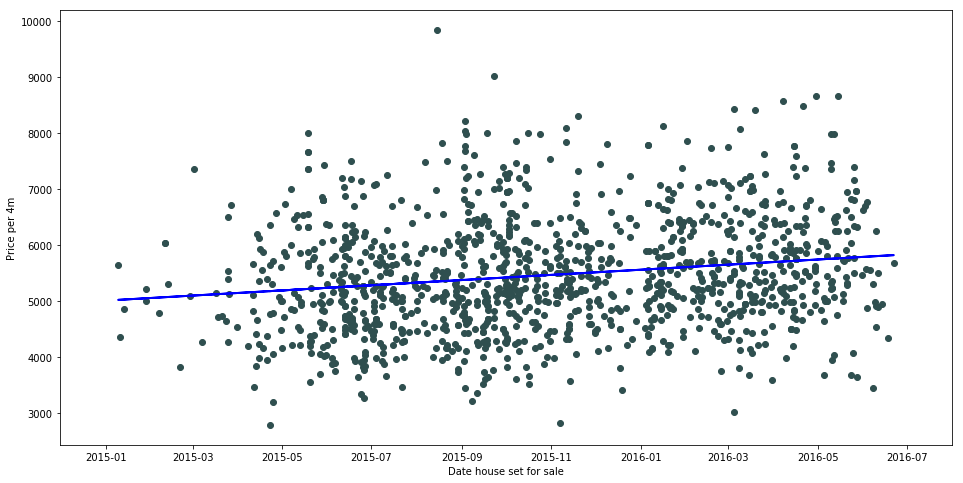

In [21]:
processed_data_Linear = pd.DataFrame()
processed_data_Linear['plaats_dt'] = processed_data_zoom['plaats_dt']
processed_data_Linear['plaats_dt_read'] = processed_data_zoom['plaats_dt']
processed_data_Linear['gem2'] = processed_data_zoom['gem2']
processed_data_Linear['plaats_dt'] = pd.to_datetime(processed_data_Linear['plaats_dt']).apply(lambda date: date.toordinal())

X = processed_data_Linear['plaats_dt'].values.reshape(-1,1)
y = processed_data_Linear['gem2'].values.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)

predictions = reg.predict(X)
plt.figure(figsize=(16, 8))
plt.scatter(
    processed_data_Linear['plaats_dt_read'],
    processed_data_Linear['gem2'],
    c='DarkSlateGray'
)
plt.plot(
    processed_data_Linear['plaats_dt'],
    predictions,
    c='blue',
    linewidth=2
)
plt.xlabel("Date house set for sale")
plt.ylabel("Price per 4m")
plt.show()

Much better.
&nbsp;

We can clearly see that there is an increase in house prices.

If we plot this result on a map, we see the following:

In [22]:
#Zoomed in loop from Amsterdam
output_notebook()
pngteller = 0
teller = 1
#for _ in range(1):

intervalmin = 1
intervalmax = intervalmin+ teller



datefrommin = processed_data_zoom['plaats_dt'].min()
#the unit of time can be defined here
datefrommax = datefrommin+ relativedelta(weeks=intervalmax)

processed_data_pp2 = processed_data_zoom[processed_data_zoom.plaats_dt > datefrommin]
#processed_data_pp2 = processed_data_zoom[processed_data_zoom.plaats_dt < datefrommax] 
datestamp = str(datefrommax)



map_options = GMapOptions(lat=52.370216, lng=4.895168, map_type="roadmap", zoom=14)
plot = GMapPlot(
    x_range=Range1d(), y_range=Range1d(), map_options=map_options, width=500, height=500, toolbar_location=None
)
plot.title.text = "Huizen prijzen per m2 op "+datestamp

plot.api_key = gmaps_key_bokeh

source = ColumnDataSource(
    data=dict(
        lat=processed_data_pp2.latitude.tolist(),
        lon=processed_data_pp2.longitude.tolist(),
        color=processed_data_pp2.gem2.tolist()
    )
)

max_median_house_value = processed_data_zoom.loc[processed_data_zoom['gem2'].idxmax()]['gem2']
min_median_house_value = processed_data_zoom.loc[processed_data_zoom['gem2'].idxmin()]['gem2']


color_mapper = LogColorMapper(palette=RdYlGn8, low=min_median_house_value, high=max_median_house_value)


circle = Circle(x="lon", y="lat", size=9, fill_color={'field': 'color', 'transform': color_mapper}, fill_alpha=0.75, 
                line_color="black")
plot.add_glyph(source, circle)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                         label_standoff=12, border_line_color=None, location=(0,0))

plot.add_layout(color_bar, 'right')

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())


#print (min_median_house_value)
#print (max_median_house_value)

show(plot)

#output_file("gmap_plot.html")

#selium is needed for a PNG output    
pngteller = int(pngteller)
pngteller = pngteller + 1
pngteller = str(pngteller)

# export_png(plot, filename="plot"+pngteller+".png")
#print (teller)
#teller = teller + 1

#extra
# Give output filepath
#outfp = r"C:\Users\tramp\Documents\Python_project_houseM\points.html"

# Save the plot by passing the plot -object and output path
#save(obj=plot, filename=outfp)



Loading BokehJS ...

<img src="vb3.PNG">

The plot above clearly shows where which house is put up for sale and for what price.

Because of this we have a fallback when we convert this plot to a heat map (A check if the information can be explained).

From there we can make an animation to see if this trend of house prices moves around or randomly emerges.

- Moves around: That could mean that house prices can be contagious to each other
- Randomly emerges: Meaning that there is no relationship in house prices

## The heatmap

In [23]:

processed_data_heatmap = pd.DataFrame()
processed_data_heatmap['latitude'] = processed_data_zoom['latitude']
processed_data_heatmap['longitude'] = processed_data_zoom['longitude']
processed_data_heatmap['gem2'] = processed_data_zoom['gem2']
#processed_data_heatmap['plaats_dt'] = processed_data_zoom['plaats_dt']
#processed_data_heatmap['plaats_dt'] = pd.to_datetime(processed_data_Linear['plaats_dt']).apply(lambda date: date.toordinal())


# processed_data_heatmap_example = processed_data_heatmap.head() 
# print(processed_data_heatmap_example)

gmaps.configure(api_key = gmaps_key_heat) 

# processed_data_heatmap_example.to_csv('processed_data_heatmap_example.csv')
# example_heatmap = pd.read_csv('processed_data_heatmap_example.csv')


# processed_data_heatmap_example_df = gmaps.datasets.load_dataset_as_df(example_heatmap)
# processed_data_heatmap_example_df.head()


# locations = processed_data_heatmap[['latitude', 'longitude']]
# weights = processed_data_heatmap['gem2']

Amsterrdam_coordinates = (52.370216, 4.895168)


fig = gmaps.figure(center=Amsterrdam_coordinates, zoom_level=14)
heatmap_layer = gmaps.heatmap_layer(
    processed_data_heatmap[['latitude', 'longitude']], weights=processed_data_heatmap['gem2'],
    point_radius=50.0)
fig.add_layer(heatmap_layer)
#fig.figure(center=Amsterrdam_coordinates, zoom_level=16)
fig

#export_png(fig, filename="plot".png")



Figure(layout=FigureLayout(height='420px'))

<img src="vb4.PNG">

As seen above, the points of interest lies mainly in the outer ring of the center of Amstedam.

Now all that remains is to animate this data so we can see if the “red” area moves around or randomly emerge. 


<img src="AL.gif">

Te animation was done quite easily with the use of png to gif converter on the internet. It is quite time consuming to create by hand every png. But we have calculated that we only need 18 frames (1 frame per month) to give a good representation.
To make it a bit easyer we have made a litle bit of code to create a frme for each dissired month.

In [24]:

processed_data_heatmap = pd.DataFrame()
processed_data_heatmap['latitude'] = processed_data_zoom['latitude']
processed_data_heatmap['longitude'] = processed_data_zoom['longitude']
processed_data_heatmap['gem2'] = processed_data_zoom['gem2']
processed_data_heatmap['plaats_dt'] = processed_data_zoom['plaats_dt']

pdhmin = processed_data_heatmap['plaats_dt'].min()

pdhteller = 18

pdhintervalmax = 1 + pdhteller

pdhmax = pdhmin+ relativedelta(months=pdhintervalmax)

processed_data_heatmap = processed_data_heatmap[processed_data_heatmap.plaats_dt > pdhmin]
processed_data_heatmap = processed_data_heatmap[processed_data_heatmap.plaats_dt < pdhmax] 

print (pdhmax)    

gmaps.configure(api_key = gmaps_key_heat) 

Amsterrdam_coordinates = (52.370216, 4.895168)

fig = gmaps.figure(center=Amsterrdam_coordinates, zoom_level=14)
heatmap_layer = gmaps.heatmap_layer(
    processed_data_heatmap[['latitude', 'longitude']], 
    weights=processed_data_heatmap['gem2'],
    point_radius=50.0)
heatmap_layer.max_intensity = 100000
fig.add_layer(heatmap_layer)


2016-08-09 00:00:00


<img src="ALslow.gif">

## Analyse


In some places the price increase is the same as the environment around it (as seen in the center).

<img src="alcenter.png">

However, If you look closely, you can see that a few trends emerge from different places in the  animation. 
It can also be seen in other places that the price increase has a course in a certain direction.


<img src="AL2.PNG"> <img src="AL3.PNG">
<img src="AL1.PNG"> <img src="AL4.PNG">

Or in another place:
<img src="AL2_1.PNG">
<img src="AL2_2.PNG">


The answer to the question "Are house prices contagious?" is yes, but to a certain extent. Since there is sometimes a certain course present. But also sometimes you see the house price rise in random places. 

Now this latest analysis method is based on a heat map from Google.
However, it is not clear how this is structured. 
For this project it is not certain whether this method is the best solution for visualization for the housing market.
In a follow-up project it can be further investigated whether other methods provide a better picture of the contagiousness of the housing market.